In [7]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy_gpu as ppy
import easydarkfigs
from tqdm import tqdm
%matplotlib inline

In [8]:
%set_darkfigdir figures_dark/
%set_lightfigdir figures/

In [3]:
f = ppy.instrument.default_NGC3377_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

Please wait while the GPU states are initialized

In [4]:
model_1 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(),
    ppy.dustmodels.SingleDust(dust_frac=0.5),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.FixedDistance(30.21),
)

In [5]:
model_2 = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(),
    ppy.dustmodels.SingleDust(dust_frac=0.5),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance(),
)

In [6]:
res = {}
for r in [21, 61, 121]:
    res[f'm1_r{r}'] = ppy.results.ResultsPlotter(f'results/NGC3377_m1_r{r}.csv', gal_model=model_1, run_name=f'NGC 3377 Region {r}')
    res[f'm2_r{r}'] = ppy.results.ResultsPlotter(f'results/NGC3377_m2_r{r}.csv', gal_model=model_2, run_name=f'NGC 3377 Region {r}')    

In [11]:
data = {}
for r in [21, 61, 121]:
    data[f'm1_r{r}'] = data[f'm2_r{r}'] = np.loadtxt(f'../data/NGC3377/pcmds/NGC3377_z_gz_{r}.pcmd', unpack=True)

In [22]:
pcmds = {}
for k in tqdm(res.keys()):
    p = res[k].best_params
    mod = (model_2 if 'm2' in k else model_1)
    mod.set_params(p)
    pcmds[k], _ = driv.simulate(mod, 512, sky_noise=[140., 90.], shot_noise=True)

100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


In [56]:
p_est = {
    'm2_r21': np.array([0., -2., 3.6, 2.0, 30.21]),
    'm2_r61': np.array([0., -2., 4.0, 2.0, 30.21]),
    'm2_r121': np.array([-0.3, -2., 4.8, 2.0, 30.21])
}

pcmds_est = {}
for k in tqdm(p_est.keys()):
    p = p_est[k]
    mod = (model_2 if 'm2' in k else model_1)
    mod.set_params(p)
    pcmds_est[k], _ = driv.simulate(mod, 512, sky_noise=[140., 90.], shot_noise=True)

100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


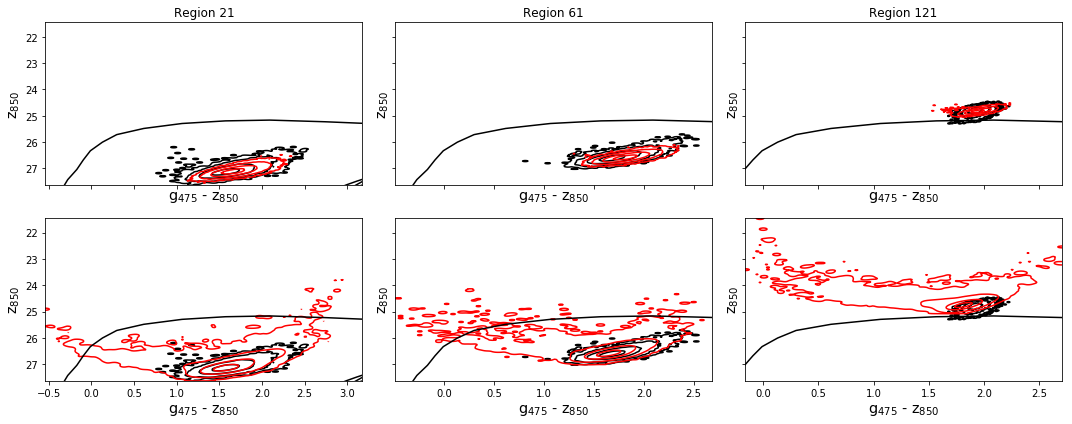

In [57]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 6), sharex='col', sharey=True)

ppy.plotting.plot_pcmd_contours(data['m2_r21'], ax=axes[0,0], keep_limits=False, color='k')
ppy.plotting.plot_pcmd_contours(data['m2_r61'], ax=axes[0,1], keep_limits=True, color='k')
ppy.plotting.plot_pcmd_contours(data['m2_r121'], ax=axes[0,2], keep_limits=True, color='k')
ppy.plotting.plot_pcmd_contours(data['m2_r21'], ax=axes[1,0], keep_limits=True, color='k')
ppy.plotting.plot_pcmd_contours(data['m2_r61'], ax=axes[1,1], keep_limits=True, color='k')
ppy.plotting.plot_pcmd_contours(data['m2_r121'], ax=axes[1,2], keep_limits=True, color='k')

ppy.plotting.plot_pcmd_contours(pcmds['m2_r21'], ax=axes[1,0], keep_limits=True, ls='-', color='r')
ppy.plotting.plot_pcmd_contours(pcmds['m2_r61'], ax=axes[1,1], keep_limits=True, ls='-', color='r')
ppy.plotting.plot_pcmd_contours(pcmds['m2_r121'], ax=axes[1,2], keep_limits=True, ls='-', color='r')

ppy.plotting.plot_pcmd_contours(pcmds_est['m2_r21'], ax=axes[0,0], keep_limits=True, ls='-', color='r')
ppy.plotting.plot_pcmd_contours(pcmds_est['m2_r61'], ax=axes[0,1], keep_limits=True, ls='-', color='r')
ppy.plotting.plot_pcmd_contours(pcmds_est['m2_r121'], ax=axes[0,2], keep_limits=True, ls='-', color='r')


axes[0,0].set_title('Region 21')
axes[0,1].set_title('Region 61')
axes[0,2].set_title('Region 121')

for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=30.21, axes=a, mag_system='vega', update_axes=True)
plt.tight_layout()
plt.savefig('figures/NGC3377_compare.pdf')

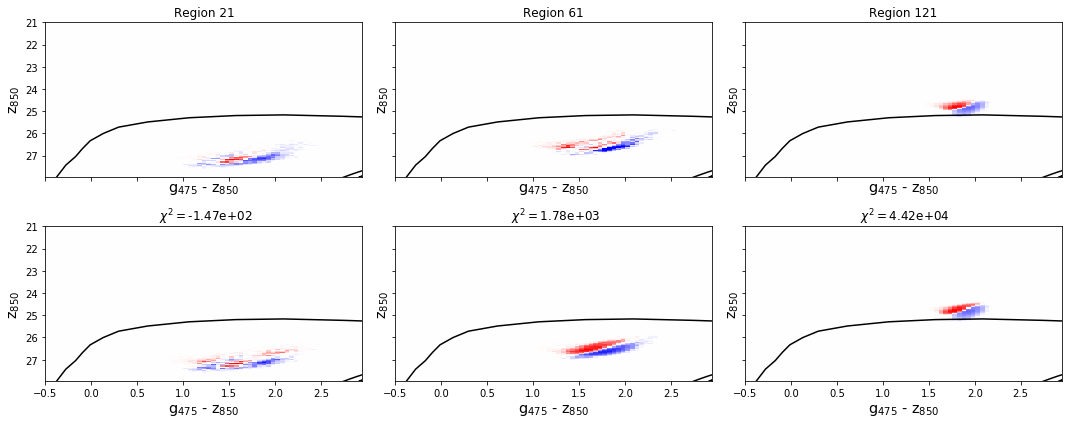

In [42]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 6), sharex='col', sharey=True)

bins = [np.arange(21, 28, 0.05), np.arange(-0.5, 3.0, 0.05)]

ppy.plotting.plot_pcmd_residual(pcmds['m1_r21'], data['m1_r21'], bins=bins, ax=axes[0,0], keep_limits=False)
ppy.plotting.plot_pcmd_residual(pcmds['m1_r61'], data['m1_r61'], bins=bins, ax=axes[0,1], keep_limits=True)
ppy.plotting.plot_pcmd_residual(pcmds['m1_r121'], data['m1_r121'], bins=bins, ax=axes[0,2], keep_limits=True)
ppy.plotting.plot_pcmd_residual(pcmds['m2_r21'], data['m1_r21'], bins=bins, ax=axes[1,0], keep_limits=True)
ppy.plotting.plot_pcmd_residual(pcmds['m2_r61'], data['m1_r61'], bins=bins, ax=axes[1,1], keep_limits=True)
ppy.plotting.plot_pcmd_residual(pcmds['m2_r121'], data['m1_r121'], bins=bins, ax=axes[1,2], keep_limits=True)

# ppy.plotting.plot_pcmd_contours(pcmds['m1_r21'], ax=axes[1,0], keep_limits=True, ls='--')
# ppy.plotting.plot_pcmd_contours(pcmds['m1_r61'], ax=axes[1,1], keep_limits=True, ls='--')
# ppy.plotting.plot_pcmd_contours(pcmds['m1_r121'], ax=axes[1,2], keep_limits=True, ls='--')

# ppy.plotting.plot_pcmd_contours(pcmds['m2_r21'], ax=axes[0,0], keep_limits=True, ls='-')
# ppy.plotting.plot_pcmd_contours(pcmds['m2_r61'], ax=axes[0,1], keep_limits=True, ls='-')
# ppy.plotting.plot_pcmd_contours(pcmds['m2_r121'], ax=axes[0,2], keep_limits=True, ls='-')


axes[0,0].set_title('Region 21')
axes[0,1].set_title('Region 61')
axes[0,2].set_title('Region 121')

for a in axes.flatten():
    ppy.plotting.plot_isochrone(iso_model, dmod=30.21, axes=a, mag_system='vega', update_axes=True)
plt.tight_layout()
plt.savefig('figures/NGC3377_resid.pdf')